# [hotsline](https://github.com/AntoineGrimaldi/hotsline) algorithm to replicate results from [this paper](https://www.techrxiv.org/articles/preprint/A_robust_event-driven_approach_to_always-on_object_recognition/18003077/1)
## Load events of the NMNIST dataset with [Tonic](https://tonic.readthedocs.io/en/latest/index.html)

In [7]:
import tonic, torch, os, pickle
%cd ../hots
from utils import get_loader, get_sliced_loader, get_dataset_info, HOTS_Dataset, make_histogram_classification, fit_mlr, predict_mlr, score_classif_events
from network import network
from timesurface import timesurface
import matplotlib.pyplot as plt

print(f' Tonic version installed -> {tonic.__version__}')

transform = tonic.transforms.NumpyAsType(int)
dataset = tonic.datasets.DVSGesture(save_to='../../Data/', train=True, transform=transform)
#get_dataset_info(dataset, properties = ['time', 'mean_isi', 'nb_events']);
print(f'number of samples in the dataset: {len(dataset)}')

/home/INT/grimaldi.a/Documents/projets/HOTS/hotsline/hots
 Tonic version installed -> 1.0.19
number of samples in the dataset: 1077


../../Data/DVSGesture/metadata/gesture_1000_True_True
Read metadata from disk.
../../Data/DVSGesture/metadata/gesture_1000_True_True
Read metadata from disk.
../../Data/DVSGesture/metadata/gesture_1000_True_False
Read metadata from disk.
number of samples in the training set: 99
number of samples in the testing set: 22
../Records/networks/2022-04-22_gesture_homeohots_True_[16, 32]_[100000.0, 800000.0]_[4, 8].pkl
Number of chance decisions: 0
90th quantile for number of events: 16171.300000000003
Mean accuracy: 43.0%
For tau = 30000000.0 last accuracy: 50.0% - mean accuracy: 43.013283926105395%
Number of chance decisions: 0
90th quantile for number of events: 16171.300000000003
Mean accuracy: 48.3%
For tau = 50000000.0 last accuracy: 68.18181818181817% - mean accuracy: 48.27476054039975%
Number of chance decisions: 0
90th quantile for number of events: 16171.300000000003
Mean accuracy: 41.099999999999994%
For tau = 70000000.0 last accuracy: 45.45454545454545% - mean accuracy: 41.0592739

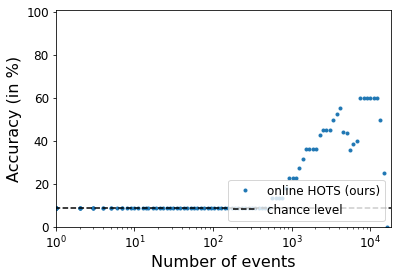

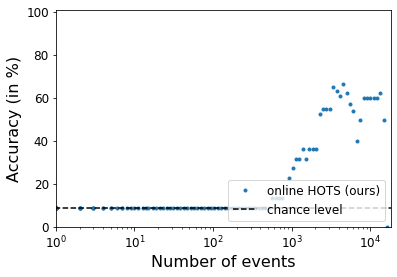

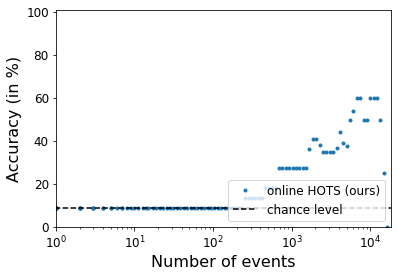

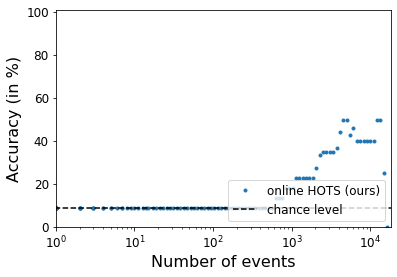

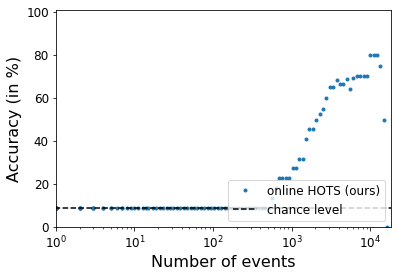

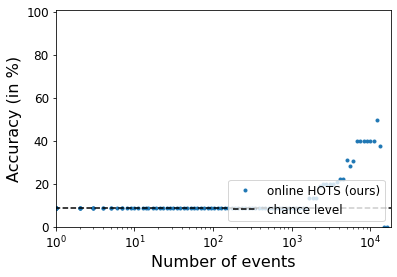

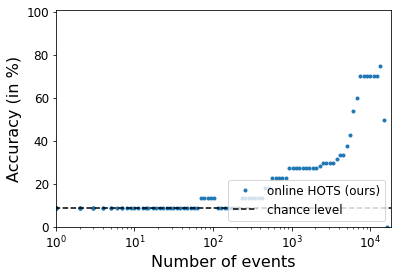

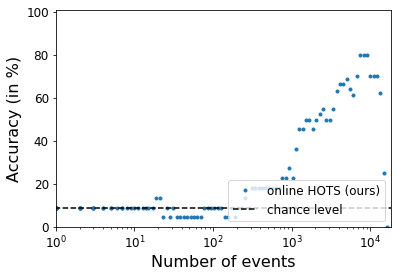

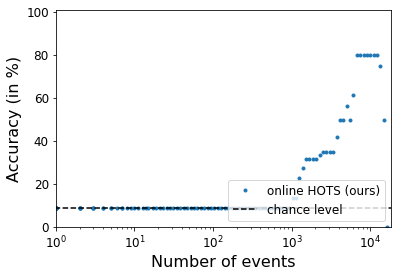

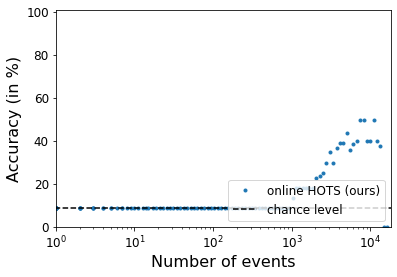

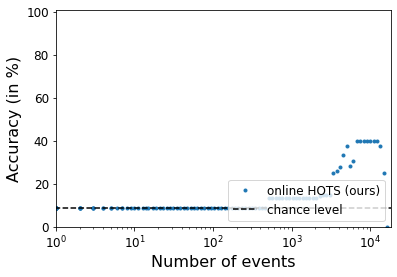

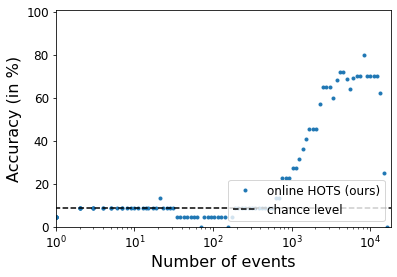

In [13]:
lr = .005
tau_cla_list_5 = [5e4, 7e4, 1e5, 2e5, 3e5, 5e5, 1e6, 2e6, 3e6, 4e6, 5e6, 7e6, 1e7, 2e7]
lr = .0005
tau_cla_list_05 = [5e4, 7e4, ]
lr = .0001
tau_cla_list_01 = [3e7, 5e7, 7e7, 1e8, 2e8, 3e8, 4e8, 5e8, 7e8, 15e7, 25e7, 1e9]

kfold_test = 10
kfold_clust = 10
ts_batch_size = 2000

dataset_name = 'gesture'
slicing_time_window = 1e6

type_transform = tonic.transforms.NumpyAsType(int)
trainset = tonic.datasets.DVSGesture(save_to='../../Data/', train=True, transform=type_transform)
testset = tonic.datasets.DVSGesture(save_to='../../Data/', train=False, transform=type_transform)
loader = get_sliced_loader(trainset, slicing_time_window, dataset_name, True, only_first=True, kfold=kfold_clust)
trainloader = get_sliced_loader(trainset, slicing_time_window, dataset_name, True, only_first=True, kfold=kfold_test)
num_sample_train = len(trainloader)
testloader = get_sliced_loader(testset, slicing_time_window, dataset_name, False, only_first=True, kfold=kfold_test)
num_sample_test = len(testloader)
n_classes = len(testset.classes)
print(f'number of samples in the training set: {len(trainloader)}')
print(f'number of samples in the testing set: {len(testloader)}')

name = 'homeohots'
homeo = True
timestr = '2022-04-22'

Rz = [4, 8]
N_neuronz = [16, 32]
tauz = [5e4*2, 5e4*16]

hots = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo)

#initial_name = hots.name

filtering_threshold = [2*Rz[L] for L in range(len(Rz))]
if not os.path.exists('../Records/'):
    os.mkdir('../Records/')
    os.mkdir('../Records/networks/')
path = '../Records/networks/'+hots.name+'.pkl'
print(path)
if not os.path.exists(path):
    hots.clustering(loader, trainset.ordering, filtering_threshold = filtering_threshold)
    
jitter = (None, None)
num_workers = 0
learning_rate = 0.0001
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 8#2 ** 5 + 1
N_output_neurons = N_neuronz[-1]
ts_size = (trainset.sensor_size[0],trainset.sensor_size[1],N_output_neurons)
tau_cla_list = [5e4, 7e4]#, 1e5, 2e5, 3e5, 5e5, 1e6]

train_path = f'../Records/output/train/{hots.name}_{num_sample_train}_{jitter}/'
test_path = f'../Records/output/test/{hots.name}_{num_sample_test}_{jitter}/'

hots.coding(trainloader, trainset.ordering, trainset.classes, training=True, verbose=False)
hots.coding(testloader, testset.ordering, testset.classes, training=False, verbose=False)

drop_proba = .5
drop_transform = tonic.transforms.DropEvent(p = drop_proba)

#trainset_output = HOTS_Dataset(train_path, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=tonic.transforms.Compose([drop_transform, type_transform]))
#trainoutputloader = get_loader(trainset_output)
#testset_output = HOTS_Dataset(test_path, testset.sensor_size, testset.classes, dtype=testset.dtype, transform=tonic.transforms.Compose([drop_transform, type_transform]))
#testoutputloader = get_loader(testset_output)

#score = make_histogram_classification(trainset_output, testset_output, N_neuronz[-1])
score_nohomeo = 0
score = 0
#print(testset_output.classes)

for tau_cla in tau_cla_list_01:

    model_path = f'../Records/networks/{hots.name}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{jitter}.pkl'
    results_path = f'../Records/LR_results/{hots.name}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{jitter}.pkl'
    #print(f'Number of samples in the trainset set: {len(trainoutputloader)}')
    
    #classif_layer, losses = fit_mlr(trainoutputloader, model_path, tau_cla, learning_rate, betas, num_epochs, ts_size, trainset.ordering, len(trainset.classes), ts_batch_size = ts_batch_size)
    #plt.plot(losses)
    #likelihood, true_target, timestamps = predict_mlr(classif_layer,tau_cla,testoutputloader,results_path,ts_size,testset_output.ordering,  ts_batch_size = ts_batch_size)
    with open(results_path, 'rb') as file:
        likelihood, true_target, timestamps = pickle.load(file)
    #for i in range(len(likelihood)):
    #    print(likelihood[i].shape)
    #    for kernel in range(likelihood[i].shape[1]):
    #        plt.plot(likelihood[i][:,kernel])
    meanac, onlinac, lastac = score_classif_events(likelihood, true_target, n_classes, original_accuracy = score, original_accuracy_nohomeo = score_nohomeo)#, figure_name = 'nmnist_online.pdf')
    print(f'For tau = {tau_cla} last accuracy: {lastac*100}% - mean accuracy: {meanac*100}%')

In [3]:
for tau_cla in tau_cla_list_05:

    model_path = f'../Records/networks/{hots.name}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{jitter}.pkl'
    results_path = f'../Records/LR_results/{hots.name}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{jitter}.pkl'
    print(f'Number of samples in the trainset set: {len(trainoutputloader)}')
    
    classif_layer, losses = fit_mlr(trainoutputloader, model_path, tau_cla, learning_rate, betas, num_epochs, ts_size, trainset.ordering, len(trainset.classes), ts_batch_size = ts_batch_size)
    #plt.plot(losses)
    likelihood, true_target, timestamps = predict_mlr(classif_layer,tau_cla,testoutputloader,results_path,ts_size,testset_output.ordering,  ts_batch_size = ts_batch_size)
    #for i in range(len(likelihood)):
    #    print(likelihood[i].shape)
    #    for kernel in range(likelihood[i].shape[1]):
    #        plt.plot(likelihood[i][:,kernel])
    meanac, onlinac, lastac = score_classif_events(likelihood, true_target, n_classes, original_accuracy = score, original_accuracy_nohomeo = score_nohomeo)#, figure_name = 'nmnist_online.pdf')
    print(f'For tau = {tau_cla} last accuracy: {lastac*100}% - mean accuracy: {meanac*100}%')

NameError: name 'trainoutputloader' is not defined

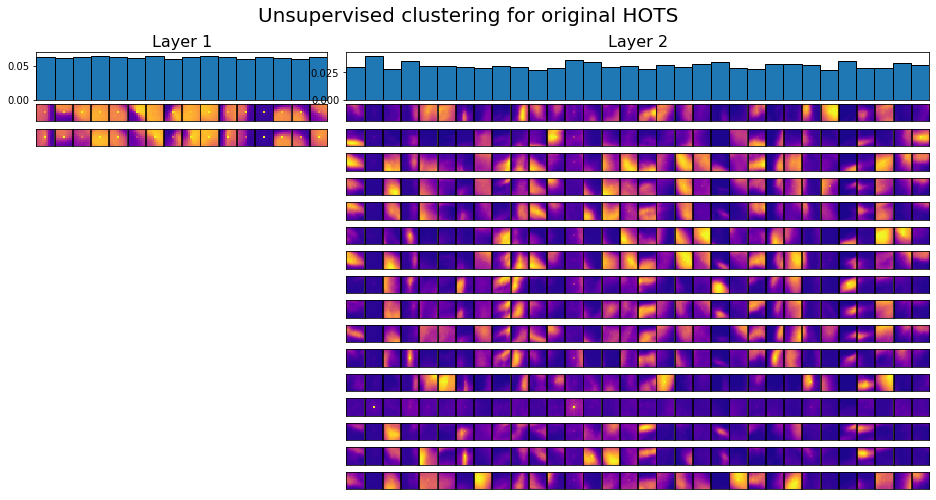

In [3]:
hots.plotlayers();

In [ ]:
kernels = classif_layer.linear.weight.data.cpu().numpy()
fig, ax = plt.subplots(N_output_neurons, kernels.shape[0], figsize=(30, 90))
for n in range(kernels.shape[0]):
    kernel = kernels[n].reshape(trainset.sensor_size[0],trainset.sensor_size[1], N_output_neurons)
    for p in range(N_output_neurons):
        ax[p, n].imshow(kernel[:,:,p])